In [1]:
import os
import sys
from importlib import reload
module_paths = [
    os.path.abspath(os.path.join('..')),
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
        
import torch
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.model_selection import train_test_split

import aav
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('darkgrid')

2024-02-27 20:40:47.613264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 20:40:47.613300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 20:40:47.614439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 20:40:47.621255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 20:40:49.832678: W tensorflow/comp

160000 160000 (160000, 84)


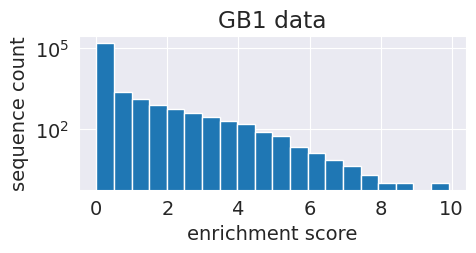

In [2]:
df = pd.read_csv('../data/elife-16965-supp1-v4.csv')
seq_n = list(df['Variants'].str.lower())  # TODO: get rid of gap character
y_n = df['Fitness'].to_numpy()
seq2y = {seq: y for seq, y in zip(seq_n, y_n)}
ohe_nxla = np.stack([utils.str2onehot(seq, aav.AA).flatten() for seq in seq_n])
ohe_nxlxa = np.stack([utils.str2onehot(seq, aav.AA) for seq in seq2y.keys()])
print(len(seq_n), y_n.size, ohe_nxla.shape)

plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('GB1 data');

In [12]:
p_n = np.exp(aav.get_loglikelihood(ohe_nxlxa, aav.LOG_PAA_NNK_LXA))
print(np.sum(p_n))

0.8807382583618164


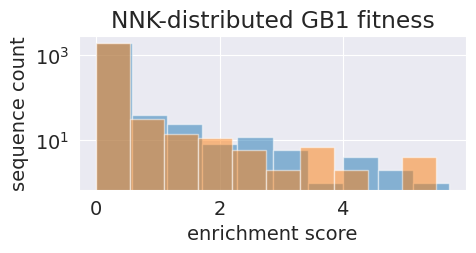

In [128]:
# generate NNK training and test data
reload(aav)
n_train = 2000
_, nnkohe_nxla, nnkseq_n = aav.sample_ohe_from_nuc_distribution(aav.PNUC_NNK_LXA, 2 * n_train)
ynnk_n = np.array([seq2y[seq] for seq in nnkseq_n])

trainohe_nxla, testohe_nxla = nnkohe_nxla[: n_train], nnkohe_nxla[n_train :]
ytrain_n, ytest_n = ynnk_n[: n_train], ynnk_n[n_train :]

plt.figure(figsize=(5, 2))
plt.hist(ytrain_n, alpha=0.5, log=True);
plt.hist(ytest_n, alpha=0.5, log=True);

plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('NNK-distributed GB1 fitness');

In [129]:
# train NN model
reload(aav)
n_epoch = 20
n_hidden = 20
n_model = 3
lr = 1e-3
batch_size = 10
n_data_workers = 1
device = torch.device(0)

model = aav.EnrichmentFeedForward(
    seq_len=4,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
loss_tx2 = model.fit(
    trainohe_nxla,
    ytrain_n,
    lr=lr,
    batch_size=batch_size,
    n_epoch=n_epoch,
    n_data_workers=n_data_workers
)

No fitness variance estimates provided. Using unweighted MSE loss.
Sequences are already one-hot encoded.
1800 training data points, 200 validation data points.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 277.21it/s]


Epoch 0. Train loss: 0.21. Val loss: 0.20. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 280.29it/s]


Epoch 1. Train loss: 0.16. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 279.05it/s]


Epoch 2. Train loss: 0.13. Val loss: 0.11. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 284.11it/s]


Epoch 3. Train loss: 0.10. Val loss: 0.11. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 278.39it/s]


Epoch 4. Train loss: 0.08. Val loss: 0.11. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 271.12it/s]


Epoch 5. Train loss: 0.07. Val loss: 0.11. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 285.56it/s]


Epoch 6. Train loss: 0.06. Val loss: 0.11. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 280.09it/s]


Epoch 7. Train loss: 0.05. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 271.66it/s]


Epoch 8. Train loss: 0.04. Val loss: 0.11. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 279.74it/s]


Epoch 9. Train loss: 0.03. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 272.02it/s]


Epoch 10. Train loss: 0.03. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 282.83it/s]


Epoch 11. Train loss: 0.02. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 283.08it/s]


Epoch 12. Train loss: 0.02. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 284.42it/s]


Epoch 13. Train loss: 0.02. Val loss: 0.13. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 284.77it/s]


Epoch 14. Train loss: 0.01. Val loss: 0.13. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 279.91it/s]


Epoch 15. Train loss: 0.01. Val loss: 0.12. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 282.85it/s]


Epoch 16. Train loss: 0.01. Val loss: 0.13. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 285.08it/s]


Epoch 17. Train loss: 0.01. Val loss: 0.13. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 286.37it/s]


Epoch 18. Train loss: 0.01. Val loss: 0.13. 0 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 287.07it/s]

Epoch 19. Train loss: 0.01. Val loss: 0.12. 0 sec.


(2000, 4, 21)


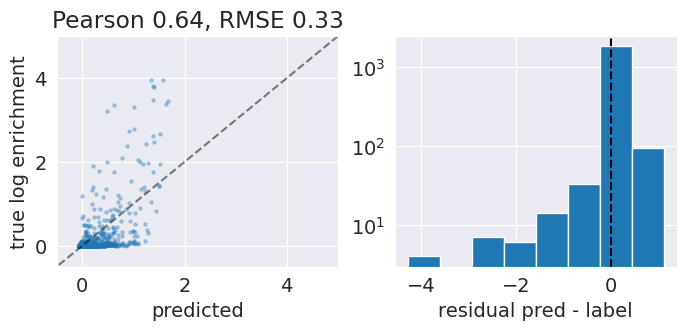

In [130]:
print(testohe_nxla.shape)
pred_n = model.predict(testohe_nxla)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(pred_n, ytest_n, alpha=0.3, s=5);
plt.plot([-5, 5], [-5, 5], '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - pred_n)))

plt.ylim([-0.5, 5]);
plt.xlim([-0.5, 5])
plt.title('Pearson {:.2f}, RMSE {:.2f}'.format(r, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

plt.subplot(122)
plt.hist(pred_n - ytest_n, bins=8, log=True);
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual pred - label');

In [72]:
model.save('/homefs/home/wongfanc/density-ratio-estimation/aav-models/022723-h20-1k_4.pt')

Saved models to /homefs/home/wongfanc/density-ratio-estimation/aav-models/022723-h20-1k_4.pt.pt.


In [83]:
# load model
reload(aav)
n_hidden = 20
n_model = 3
device = torch.device(0)

model = aav.EnrichmentFeedForward(
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('022723-h20-1k.pt')

In [91]:
# get design distributions
reload(aav)
temperatures = np.arange(0.1, 0.51, 0.01)
lr = 0.1
n_sample = 1000
n_iter = 4000
pareto_tx3 = np.empty([temperatures.size, 3])

for t, temp in enumerate(temperatures):
    print('Temperature = {:.4f}'.format(temp))
    save_fname_no_ftype = 'gb1-h20-1k-t{:.4f}-022723'.format(temp)
    # save_fname_no_ftype = None
    
    t0 = time()
    theta_lxa, df = aav.solve_max_entropy_library(
        model,
        temperature=temp,
        lr=lr,
        n_sample=n_sample,
        n_iter=n_iter,
        save_fname_no_ftype=save_fname_no_ftype
    )
    
    paa_lxa = aav.get_aa_probs_from_nuc_probs(aav.normalize_theta(theta_lxa))
    pdesign_n = np.exp(aav.get_nostop_loglikelihood(aav.ALL_NOSTOP_AA_OHE, paa_lxa))
    truemean = np.sum([p * seq2y[seq] for p, seq in zip(pdesign_n, aav.ALL_NOSTOP_AA_SEQS)])
    pareto_tx3[t] = df.loc[n_iter]['mean_prediction'], df.loc[n_iter]['epd'], truemean
    print('True mean label: {:.2f}'.format(truemean))
    print('{} sec'.format(int(time() - t0)))
    print()

Temperature = 0.1000
Iter: 1. Objective: 1.43. Mean prediction: 0.23. Mean no-stop prediction: 0.24. Entropy: 12.05. AA EPD: 3.32
Iter: 500. Objective: 3.41. Mean prediction: 2.64. Mean no-stop prediction: 2.64. Entropy: 7.71. AA EPD: 1.44
Iter: 1000. Objective: 3.82. Mean prediction: 3.16. Mean no-stop prediction: 3.17. Entropy: 6.55. AA EPD: 0.85
Iter: 1500. Objective: 4.17. Mean prediction: 3.49. Mean no-stop prediction: 3.52. Entropy: 6.84. AA EPD: 0.83
Iter: 2000. Objective: 4.22. Mean prediction: 3.56. Mean no-stop prediction: 3.54. Entropy: 6.64. AA EPD: 0.65
Iter: 2500. Objective: 4.25. Mean prediction: 3.60. Mean no-stop prediction: 3.58. Entropy: 6.52. AA EPD: 0.59
Iter: 3000. Objective: 4.24. Mean prediction: 3.60. Mean no-stop prediction: 3.59. Entropy: 6.47. AA EPD: 0.60
Iter: 3500. Objective: 4.25. Mean prediction: 3.61. Mean no-stop prediction: 3.60. Entropy: 6.39. AA EPD: 0.56
Iter: 4000. Objective: 4.27. Mean prediction: 3.63. Mean no-stop prediction: 3.61. Entropy: 6.

Iter: 2500. Objective: 5.03. Mean prediction: 3.78. Mean no-stop prediction: 3.78. Entropy: 7.81. AA EPD: 1.20
Iter: 3000. Objective: 5.03. Mean prediction: 3.78. Mean no-stop prediction: 3.78. Entropy: 7.77. AA EPD: 1.20
Iter: 3500. Objective: 5.04. Mean prediction: 3.80. Mean no-stop prediction: 3.81. Entropy: 7.72. AA EPD: 1.17
Iter: 4000. Objective: 5.07. Mean prediction: 3.83. Mean no-stop prediction: 3.81. Entropy: 7.75. AA EPD: 1.22
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.1600-022723.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.1600-022723.csv
True mean label: 4.09
235 sec

Temperature = 0.1700
Iter: 1. Objective: 2.30. Mean prediction: 0.01. Mean no-stop prediction: 0.01. Entropy: 13.50. AA EPD: 3.42
Iter: 500. Objective: 3.15. Mean prediction: 0.46. Mean no-stop prediction: 0.43. Entropy: 15.80. AA EPD: 3.66
Iter: 1000. Objective: 4.57. Mean prediction: 

True mean label: 3.94
232 sec

Temperature = 0.2300
Iter: 1. Objective: 3.19. Mean prediction: 0.24. Mean no-stop prediction: 0.24. Entropy: 12.80. AA EPD: 3.19
Iter: 500. Objective: 4.98. Mean prediction: 2.52. Mean no-stop prediction: 2.46. Entropy: 10.71. AA EPD: 2.28
Iter: 1000. Objective: 5.16. Mean prediction: 2.96. Mean no-stop prediction: 2.97. Entropy: 9.54. AA EPD: 2.04
Iter: 1500. Objective: 5.26. Mean prediction: 3.24. Mean no-stop prediction: 3.27. Entropy: 8.78. AA EPD: 1.79
Iter: 2000. Objective: 5.25. Mean prediction: 3.26. Mean no-stop prediction: 3.29. Entropy: 8.64. AA EPD: 1.73
Iter: 2500. Objective: 5.25. Mean prediction: 3.31. Mean no-stop prediction: 3.37. Entropy: 8.46. AA EPD: 1.67
Iter: 3000. Objective: 5.30. Mean prediction: 3.36. Mean no-stop prediction: 3.34. Entropy: 8.41. AA EPD: 1.66
Iter: 3500. Objective: 5.26. Mean prediction: 3.35. Mean no-stop prediction: 3.36. Entropy: 8.31. AA EPD: 1.61
Iter: 4000. Objective: 5.29. Mean prediction: 3.37. Mean no-st

Iter: 2000. Objective: 5.84. Mean prediction: 3.00. Mean no-stop prediction: 3.01. Entropy: 9.78. AA EPD: 2.48
Iter: 2500. Objective: 5.86. Mean prediction: 3.11. Mean no-stop prediction: 3.09. Entropy: 9.47. AA EPD: 2.39
Iter: 3000. Objective: 5.84. Mean prediction: 3.11. Mean no-stop prediction: 3.10. Entropy: 9.42. AA EPD: 2.39
Iter: 3500. Objective: 5.85. Mean prediction: 3.14. Mean no-stop prediction: 3.18. Entropy: 9.32. AA EPD: 2.33
Iter: 4000. Objective: 5.85. Mean prediction: 3.16. Mean no-stop prediction: 3.17. Entropy: 9.27. AA EPD: 2.34
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.2900-022723.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.2900-022723.csv
True mean label: 2.50
235 sec

Temperature = 0.3000
Iter: 1. Objective: 4.07. Mean prediction: 0.08. Mean no-stop prediction: 0.06. Entropy: 13.27. AA EPD: 3.53
Iter: 500. Objective: 5.49. Mean prediction: 1

True mean label: 3.35
235 sec

Temperature = 0.3600
Iter: 1. Objective: 5.20. Mean prediction: 0.07. Mean no-stop prediction: 0.08. Entropy: 14.26. AA EPD: 3.56
Iter: 500. Objective: 6.18. Mean prediction: 0.37. Mean no-stop prediction: 0.41. Entropy: 16.14. AA EPD: 3.70
Iter: 1000. Objective: 6.26. Mean prediction: 0.90. Mean no-stop prediction: 0.94. Entropy: 14.89. AA EPD: 3.51
Iter: 1500. Objective: 6.45. Mean prediction: 1.85. Mean no-stop prediction: 1.83. Entropy: 12.75. AA EPD: 3.15
Iter: 2000. Objective: 6.49. Mean prediction: 2.30. Mean no-stop prediction: 2.36. Entropy: 11.63. AA EPD: 2.93
Iter: 2500. Objective: 6.51. Mean prediction: 2.51. Mean no-stop prediction: 2.58. Entropy: 11.11. AA EPD: 2.81
Iter: 3000. Objective: 6.61. Mean prediction: 2.72. Mean no-stop prediction: 2.71. Entropy: 10.80. AA EPD: 2.58
Iter: 3500. Objective: 6.74. Mean prediction: 3.10. Mean no-stop prediction: 3.06. Entropy: 10.13. AA EPD: 2.23
Iter: 4000. Objective: 6.68. Mean prediction: 3.11. Mean

Iter: 2000. Objective: 7.16. Mean prediction: 0.70. Mean no-stop prediction: 0.70. Entropy: 15.38. AA EPD: 3.58
Iter: 2500. Objective: 7.18. Mean prediction: 0.72. Mean no-stop prediction: 0.69. Entropy: 15.38. AA EPD: 3.57
Iter: 3000. Objective: 7.20. Mean prediction: 0.79. Mean no-stop prediction: 0.74. Entropy: 15.25. AA EPD: 3.57
Iter: 3500. Objective: 7.13. Mean prediction: 0.83. Mean no-stop prediction: 0.88. Entropy: 15.01. AA EPD: 3.53
Iter: 4000. Objective: 7.15. Mean prediction: 1.04. Mean no-stop prediction: 1.09. Entropy: 14.56. AA EPD: 3.45
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.4200-022723.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.4200-022723.csv
True mean label: 0.92
237 sec

Temperature = 0.4300
Iter: 1. Objective: 6.06. Mean prediction: 0.22. Mean no-stop prediction: 0.19. Entropy: 13.57. AA EPD: 3.49
Iter: 500. Objective: 7.33. Mean predicti

Iter: 4000. Objective: 8.14. Mean prediction: 0.32. Mean no-stop prediction: 0.32. Entropy: 16.29. AA EPD: 3.71
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.4800-022723.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h20-1k-t0.4800-022723.csv
True mean label: 0.26
238 sec

Temperature = 0.4900
Iter: 1. Objective: 6.43. Mean prediction: 0.03. Mean no-stop prediction: 0.02. Entropy: 13.06. AA EPD: 3.50
Iter: 500. Objective: 8.31. Mean prediction: 0.28. Mean no-stop prediction: 0.23. Entropy: 16.38. AA EPD: 3.73
Iter: 1000. Objective: 8.35. Mean prediction: 0.32. Mean no-stop prediction: 0.30. Entropy: 16.38. AA EPD: 3.73
Iter: 1500. Objective: 8.29. Mean prediction: 0.28. Mean no-stop prediction: 0.28. Entropy: 16.35. AA EPD: 3.73
Iter: 2000. Objective: 8.28. Mean prediction: 0.26. Mean no-stop prediction: 0.29. Entropy: 16.38. AA EPD: 3.73
Iter: 2500. Objective: 8.34. Mean predicti

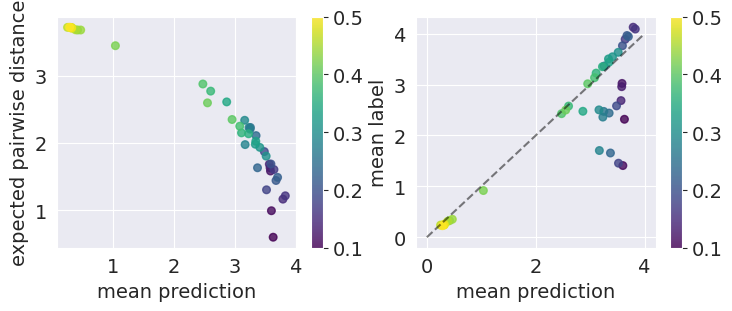

In [92]:
plt.figure(figsize=(8.5, 3))
plt.subplot(121)
plt.scatter(pareto_tx3[:, 0], pareto_tx3[:, 1], s=30, alpha=0.8, c=temperatures, cmap='viridis')
plt.colorbar()
plt.xlabel('mean prediction');
plt.ylabel('expected pairwise distance');
plt.subplot(122)
plt.scatter(pareto_tx3[:, 0], pareto_tx3[:, 2], s=30, alpha=0.8, c=temperatures, cmap='viridis')
plt.plot([0, 4], [0, 4], '--k', alpha=0.5)
plt.colorbar()
plt.xlabel('mean prediction');
plt.ylabel('mean label');

In [93]:
PATH = '/homefs/home/wongfanc/density-ratio-estimation/aav-models/'
temperatures = np.arange(0.1, 0.51, 0.01)
temp2theta = {
    temp: np.load(PATH + 'gb1-h20-1k-t{:.4f}-022723.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}

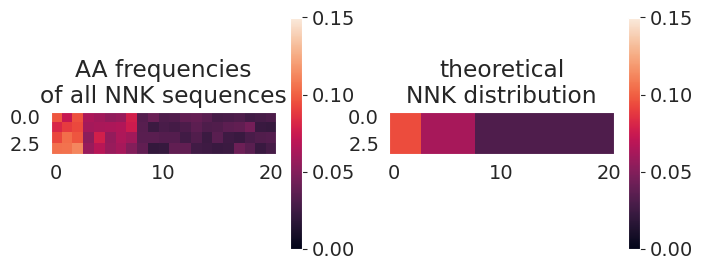

In [14]:
# sanity checking theoretical and empirical NNK distributions
n_val = 1000
_, valohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(aav.PNUC_NNK_LXA, n_val)
fit_lxa = aav.fit_mle_paa(valohe_nxlxa)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(fit_lxa, vmin=0, vmax=0.15)
plt.title('AA frequencies\nof all NNK sequences')
plt.grid(None)
plt.colorbar();
plt.subplot(122)
plt.imshow(aav.PAA_NNK_LXA, vmin=0, vmax=0.15)
plt.title('theoretical\nNNK distribution')
plt.grid(None)
plt.colorbar();

0.10781686136743122
Calibration ESS: 502
0.10781686136743122
0.03158848323905261
Mean design prediction: 1.1068. Mean IW calibration prediction: 1.1011


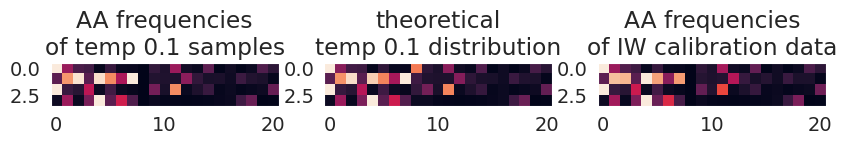

In [137]:
# sanity checking theoretical and empirical design distributions
# using design data and IW calibration data
reload(aav)
n_design = 100000
n_cal = 100000
temp = 0.1

# true frequencies
design_pnuc_lxa = aav.normalize_theta(temp2theta[temp])
design_paa_lxa = aav.get_aa_probs_from_nuc_probs(design_pnuc_lxa)

# fit frequencies to design samples
_, designohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
    temp2theta[temp], n_design, normalize=True, reject_stop_codon=True)
fit_lxa = aav.fit_mle_paa(designohe_nxlxa)
print(np.max(np.abs(fit_lxa - design_paa_lxa)))

# design predictions
preddesign_n = model.predict(designohe_nxlxa)
imputed_mean = np.mean(preddesign_n)
    
    
# fit frequencies to IWed calibration data 
_, calohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
    aav.PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True)
caldr_n = aav.get_density_ratios(calohe_nxlxa, temp2theta[temp])
ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
print('Calibration ESS: {}'.format(int(ess)))
caldr_n = caldr_n / np.sum(caldr_n) * n_cal
iwfit_lxa = aav.fit_mle_paa(calohe_nxlxa, weight_n=caldr_n)
print(np.max(np.abs(iwfit_lxa - design_paa_lxa)))
print(np.max(np.abs(iwfit_lxa - fit_lxa)))

# IW calibration predictions
predcal_n = model.predict(calohe_nxlxa)
iw_cal_mean = np.mean(caldr_n * predcal_n)
print('Mean design prediction: {:.4f}. Mean IW calibration prediction: {:.4f}'.format(
    imputed_mean, iw_cal_mean
))

# plot
plt.figure(figsize=(10, 2))
plt.subplot(131)
plt.imshow(fit_lxa, vmin=0, vmax=0.15)
plt.title('AA frequencies\nof temp {} samples'.format(temp))
plt.grid(None)
# plt.colorbar();
plt.subplot(132)
plt.imshow(design_paa_lxa, vmin=0, vmax=0.15)
plt.title('theoretical\ntemp {} distribution'.format(temp))
plt.grid(None)
# plt.colorbar();
plt.subplot(133)
plt.imshow(iwfit_lxa, vmin=0, vmax=0.15)
plt.title('AA frequencies\nof IW calibration data')
plt.grid(None)
# plt.colorbar();

In [94]:
reload(aav)
temp2mean = aav.get_true_mean_label_from_theta(temp2theta, seq2y) 

True mean label for temperature...
    0.1000 is 2.3177. (0 sec)
    0.1100 is 1.4080. (0 sec)
    0.1200 is 3.0225. (0 sec)
    0.1300 is 2.9582. (1 sec)
    0.1400 is 2.6846. (1 sec)
    0.1500 is 4.1265. (1 sec)
    0.1600 is 4.0908. (1 sec)
    0.1700 is 3.8891. (1 sec)
    0.1800 is 1.4545. (2 sec)
    0.1900 is 2.5811. (2 sec)
    0.2000 is 3.7626. (2 sec)
    0.2100 is 3.9639. (2 sec)
    0.2200 is 3.9425. (2 sec)
    0.2300 is 1.6553. (3 sec)
    0.2400 is 2.4395. (3 sec)
    0.2500 is 3.3629. (3 sec)
    0.2600 is 2.4721. (3 sec)
    0.2700 is 2.3605. (3 sec)
    0.2800 is 1.7036. (3 sec)
    0.2900 is 2.5024. (4 sec)
    0.3000 is 3.6334. (4 sec)
    0.3100 is 3.5460. (4 sec)
    0.3200 is 3.5039. (4 sec)
    0.3300 is 3.4380. (4 sec)
    0.3400 is 2.4748. (5 sec)
    0.3500 is 3.3506. (5 sec)
    0.3600 is 3.2251. (5 sec)
    0.3700 is 2.5768. (5 sec)
    0.3800 is 3.1343. (5 sec)
    0.3900 is 2.4280. (5 sec)
    0.4000 is 3.0152. (6 sec)
    0.4100 is 2.4991. (6 sec)
    0

In [15]:
reload(aav)
temp2mean = aav.get_true_mean_label_from_theta(temp2theta, seq2y) 

True mean label for temperature...
    0.1000 is 4.9366. (0 sec)
    0.2000 is 2.5716. (0 sec)
    0.3000 is 1.2882. (1 sec)
    0.4000 is 0.2361. (1 sec)
    0.5000 is 0.1421. (1 sec)


3.1237195459767526 4.936618907090937


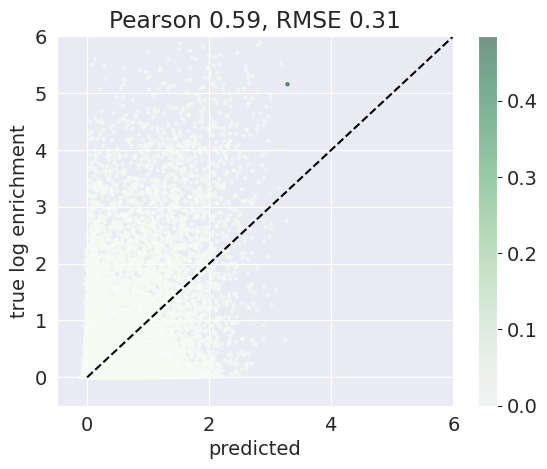

In [16]:
temp = 0.1
pred_n = model.predict(seq_n)
theta_lxa = temp2theta[temp]
paa_lxa = aav.get_aa_probs_from_nuc_probs(aav.normalize_theta(theta_lxa))
ll_n = aav.get_nostop_loglikelihood(ohe_nxlxa, paa_lxa)
p_n = np.exp(ll_n)
print(np.sum(p_n * pred_n), np.sum(p_n * y_n))

plt.scatter(pred_n, y_n, c=p_n, alpha=0.5, s=5, cmap='Greens')
plt.colorbar()
plt.plot([0, 6], [0, 6], '--k')
r, p = sc.stats.pearsonr(y_n, pred_n)
rmse = np.sqrt(np.mean(np.square(y_n - pred_n)))

plt.ylim([-0.5, 6]);
plt.xlim([-0.5, 6])
plt.title('Pearson {:.2f}, RMSE {:.2f}'.format(r, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

In [109]:
# mean
reload(aav)
n_design = 100000
n_cal = 1000

truemean_t = []
pp_t = []
imputed_t = []

for temp in temperatures:
    
    print(temp)

    theta_lxa = temp2theta[temp]

    # sample from design distribution and get predictions
    _, designohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
        theta_lxa, n_design, normalize=True, reject_stop_codon=True
    )
    preddesign_n = model.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n)
    imputed_t.append(imputed_mean)

    # sample calibration data from NNK
    _, calohe_nxlxa, calseq_n = aav.sample_ohe_from_nuc_distribution(
        aav.PNUC_NNK_LXA, n_cal, reject_stop_codon=True
    )
    ycal_n = np.array([seq2y[seq] for seq in calseq_n])

    # weight NNK calibration data
    caldr_n = aav.get_density_ratios(calohe_nxlxa, theta_lxa)
    # caldr_n = caldr_n / np.sum(caldr_n) * n_cal
    ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
    
    # IW calibration estimates
    predcal_n = model.predict(calohe_nxlxa) 
    iw_cal_mean = np.mean(caldr_n * predcal_n)
    rect = np.mean(caldr_n * (ycal_n - predcal_n))
    
    pp = imputed_mean + rect
    pp_t.append(pp)
    truemean_t.append(temp2mean[temp])
    
    # print('Mean NNK label: {:.3f}'.format(np.mean(ycal_n)))
    print('Calibration ESS: {}'.format(int(ess)))
    print('Imputed mean: {:.3f}, IW mean calibration prediction: {:.3f}'.format(imputed_mean, iw_cal_mean))
    print('True mean:    {:.3f}, IW mean calibration label: {:.3f}, PP estimate: {:.3f}'.format(
        temp2mean[temp], np.mean(caldr_n * ycal_n), pp))
    print()

0.1
Calibration ESS: 2
Imputed mean: 3.616, IW mean calibration prediction: 0.021
True mean:    2.318, IW mean calibration label: 0.015, PP estimate: 3.610

0.11
Calibration ESS: 1
Imputed mean: 3.607, IW mean calibration prediction: 0.004
True mean:    1.408, IW mean calibration label: 0.001, PP estimate: 3.603

0.12
Calibration ESS: 1
Imputed mean: 3.595, IW mean calibration prediction: 0.184
True mean:    3.023, IW mean calibration label: 0.117, PP estimate: 3.528

0.13
Calibration ESS: 2
Imputed mean: 3.595, IW mean calibration prediction: 1.058
True mean:    2.958, IW mean calibration label: 0.822, PP estimate: 3.358

0.13999999999999999
Calibration ESS: 2
Imputed mean: 3.580, IW mean calibration prediction: 0.623
True mean:    2.685, IW mean calibration label: 0.438, PP estimate: 3.395

0.14999999999999997
Calibration ESS: 1
Imputed mean: 3.799, IW mean calibration prediction: 0.039
True mean:    4.127, IW mean calibration label: 0.044, PP estimate: 3.805

0.15999999999999998
Cal

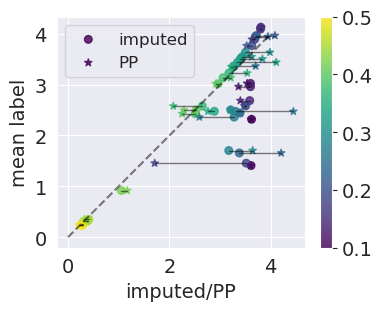

In [112]:
plt.figure(figsize=(4, 3))
plt.scatter(imputed_t, truemean_t, s=30, alpha=0.8, c=temperatures, cmap='viridis', label='imputed')
plt.scatter(pp_t, truemean_t, s=30, alpha=0.8, marker='*', c=temperatures, cmap='viridis', label='PP')
for imp, pp, true in zip(imputed_t, pp_t, truemean_t):
    plt.plot([imp, pp], [true, true], c='k', linewidth=1, alpha=0.5)
plt.legend(fontsize=12);
plt.colorbar()
plt.xlabel('imputed/PP');
plt.ylabel('mean label');
plt.plot([0, 4], [0, 4], '--k', alpha=0.5);

In [114]:
reload(aav)
threshold = 1
seq2ythresh = {seq: (y >= threshold).astype(float) for seq, y in seq2y.items()}
temp2meanthresh = aav.get_true_mean_label_from_theta(temp2theta, seq2ythresh) 

True mean label for temperature...
    0.1000 is 0.9895. (0 sec)
    0.1100 is 0.6125. (0 sec)
    0.1200 is 0.8604. (0 sec)
    0.1300 is 0.8543. (1 sec)
    0.1400 is 0.8224. (1 sec)
    0.1500 is 0.9879. (1 sec)
    0.1600 is 0.9875. (1 sec)
    0.1700 is 0.9835. (1 sec)
    0.1800 is 0.6147. (2 sec)
    0.1900 is 0.7915. (2 sec)
    0.2000 is 0.9692. (2 sec)
    0.2100 is 0.9792. (2 sec)
    0.2200 is 0.9776. (2 sec)
    0.2300 is 0.6644. (2 sec)
    0.2400 is 0.7629. (3 sec)
    0.2500 is 0.9201. (3 sec)
    0.2600 is 0.7519. (3 sec)
    0.2700 is 0.7329. (3 sec)
    0.2800 is 0.6508. (3 sec)
    0.2900 is 0.7584. (4 sec)
    0.3000 is 0.9475. (4 sec)
    0.3100 is 0.9429. (4 sec)
    0.3200 is 0.9384. (4 sec)
    0.3300 is 0.9292. (4 sec)
    0.3400 is 0.7388. (4 sec)
    0.3500 is 0.9191. (5 sec)
    0.3600 is 0.8906. (5 sec)
    0.3700 is 0.7674. (5 sec)
    0.3800 is 0.8799. (5 sec)
    0.3900 is 0.7369. (5 sec)
    0.4000 is 0.8632. (6 sec)
    0.4100 is 0.7554. (6 sec)
    0

In [124]:
# probability of exceedance
reload(aav)
n_design = 100000
n_cal = 1000
threshold = 1

truemean_t = []
imputed_t = []
pp_t = []

for temp in temperatures:
    
    print(temp)

    theta_lxa = temp2theta[temp]

    # sample from design distribution and get predictions
    _, designohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
        theta_lxa, n_design, normalize=True, reject_stop_codon=True
    )
    preddesign_n = model.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n >= threshold)
    imputed_t.append(imputed_mean)

    # sample calibration data from NNK
    _, calohe_nxlxa, calseq_n = aav.sample_ohe_from_nuc_distribution(
        aav.PNUC_NNK_LXA, n_cal, reject_stop_codon=True
    )
    ycal_n = np.array([seq2y[seq] >= threshold for seq in calseq_n]).astype(float)

    # weight NNK calibration data
    caldr_n = aav.get_density_ratios(calohe_nxlxa, theta_lxa)
    caldr_n = caldr_n / np.sum(caldr_n) * n_cal
    ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
    
    # IW calibration estimates
    predcal_n = model.predict(calohe_nxlxa) 
    predcal_n = np.array(predcal_n >= threshold).astype(float)
    iw_cal_mean = np.mean(caldr_n * predcal_n)
    rect = np.mean(caldr_n * (ycal_n - predcal_n))
    
    pp = imputed_mean + rect
    pp_t.append(pp)
    truemean_t.append(temp2meanthresh[temp])
    
    # print('Mean NNK label: {:.3f}'.format(np.mean(ycal_n)))
    print('Calibration ESS: {}'.format(int(ess)))
    print('Imputed mean: {:.3f}, IW mean calibration prediction: {:.3f}'.format(imputed_mean, iw_cal_mean))
    print('True mean:    {:.3f}, IW mean calibration label: {:.3f}, PP estimate: {:.3f}'.format(
        temp2meanthresh[temp], np.mean(caldr_n * ycal_n), pp))
    print()

0.1
Calibration ESS: 1
Imputed mean: 0.999, IW mean calibration prediction: 0.974
True mean:    0.990, IW mean calibration label: 0.023, PP estimate: 0.047

0.11
Calibration ESS: 2
Imputed mean: 0.997, IW mean calibration prediction: 0.995
True mean:    0.612, IW mean calibration label: 0.026, PP estimate: 0.029

0.12
Calibration ESS: 2
Imputed mean: 0.997, IW mean calibration prediction: 0.908
True mean:    0.860, IW mean calibration label: 0.731, PP estimate: 0.819

0.13
Calibration ESS: 1
Imputed mean: 0.996, IW mean calibration prediction: 0.995
True mean:    0.854, IW mean calibration label: 0.963, PP estimate: 0.964

0.13999999999999999
Calibration ESS: 1
Imputed mean: 0.996, IW mean calibration prediction: 0.823
True mean:    0.822, IW mean calibration label: 0.117, PP estimate: 0.290

0.14999999999999997
Calibration ESS: 7
Imputed mean: 0.997, IW mean calibration prediction: 0.080
True mean:    0.988, IW mean calibration label: 0.061, PP estimate: 0.978

0.15999999999999998
Cal

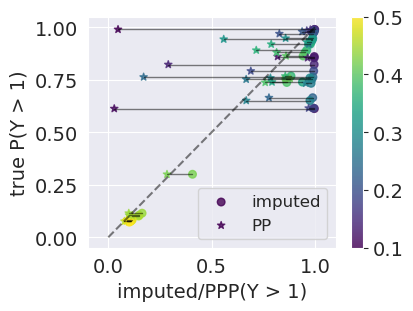

In [125]:
plt.figure(figsize=(4, 3))
plt.scatter(imputed_t, truemean_t, s=30, alpha=0.8, c=temperatures, cmap='viridis', label='imputed')
plt.scatter(pp_t, truemean_t, s=30, alpha=0.8, marker='*', c=temperatures, cmap='viridis', label='PP')
for imp, pp, true in zip(imputed_t, pp_t, truemean_t):
    plt.plot([imp, pp], [true, true], c='k', linewidth=1, alpha=0.5)
plt.legend(fontsize=12);
plt.colorbar()
plt.xlabel('imputed/PPP(Y > {})'.format(threshold));
plt.ylabel('true P(Y > {})'.format(threshold));
plt.plot([0, 1], [0, 1], '--k', alpha=0.5);
plt.xlim([-0.1, 1.1]);